# RandomForest Regressor
Haytham Mohamed

INFS 890 - Spring 2020

In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [443]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'


data_file = 'no_missing_outliers_dataset.csv'
#data_file = 'factored_dataset.csv'
#data_file = 'standardized_normalized_dataset.csv'
#data_file = 'normalized_dataset.csv'


data = pd.read_csv(file_dir + data_file)

test_split=0.1


In [444]:
data.head(5)

,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,system_net_sat,system_disk_sat,system_disk_io,svc_req_size,svc_resp_size,svc_pods,svc_req_rate,ltcy
0,0.310,0.110,0.106,0.001,2.030,1.261,3.206,0.000,0.980,0.010,0.002,0.012,7.000,0.980,0.110
1,0.380,0.090,0.123,0.002,2.130,1.268,3.552,0.000,0.980,0.010,0.003,0.019,7.000,1.620,0.160
2,0.370,0.100,0.131,0.002,2.100,1.179,3.586,0.000,0.980,0.010,0.003,0.024,7.000,2.180,0.220
3,0.390,0.090,0.131,0.012,2.040,1.315,3.512,0.000,0.980,0.010,0.003,0.022,6.000,2.130,0.240
4,0.370,0.100,0.140,0.018,2.020,1.385,3.449,0.000,0.980,0.010,0.003,0.023,3.000,2.220,0.250


In [445]:
data.shape

(1584, 15)

In [446]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

n_features = inputs.values.shape[1]

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 14 features


In [447]:
# Regression

# start:  search grid

randforest = RandomForestRegressor() #(n_estimators=tree_n_estimators, max_features=tree_n_features)

# standardize the features
scaler = StandardScaler()

# no feastures selection needed for RandomTree Regressor
pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('clf', randforest)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'clf__max_features': [11, 9, 7, 5, 3]   # The maximum number of features to consider
    ,'clf__n_estimators': [10, 8, 6, 4, 2, 1]  # The number of trees in the forest 
}


search = GridSearchCV(pipe
                      , param_grid
                      , scoring='neg_mean_squared_error'
                      , return_train_score= True
                      , cv=kfold
                      , verbose=0
                      , n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_sampl

# Best Model

In [448]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])

print("")
print('Model training Score = {}'.format(search.score(x_train,y_train)))

Best CV score = -0.042:
Best CV params = {'clf__max_features': 7, 'clf__n_estimators': 8}

[-0.00409292 -0.00444744 -0.00502792 -0.00614357 -0.00935312 -0.01537194
 -0.00407948 -0.00435111 -0.00493578 -0.00597    -0.00957557 -0.01582024
 -0.00423045 -0.00454255 -0.00499996 -0.00611862 -0.00966964 -0.01642349
 -0.0042147  -0.00444419 -0.00493802 -0.0060868  -0.00953615 -0.01626055
 -0.00424675 -0.00455767 -0.00508315 -0.00641065 -0.00921588 -0.01649276]

Model training Score = -0.004472927819800597


# Training R2

In [449]:
score = search.score(x_train, y_train)
score

-0.004472927819800597

In [450]:
#scaler.fit(x_train.values.reshape(-1,n_features))
#x_train = scaler.transform(x_train)

y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))


R2 (training) = 0.8854318109366335


In [451]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.05 (0.05) 0.00 0.36 MSE


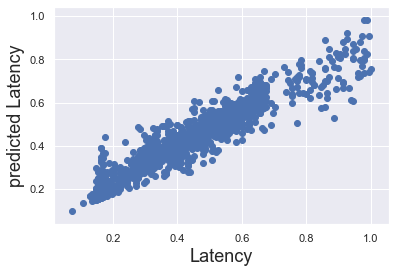

In [452]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

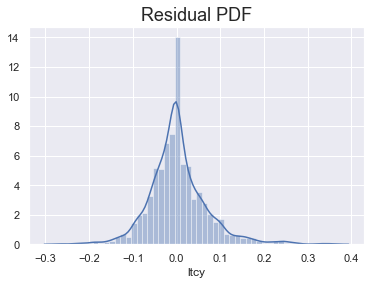

In [453]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [454]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

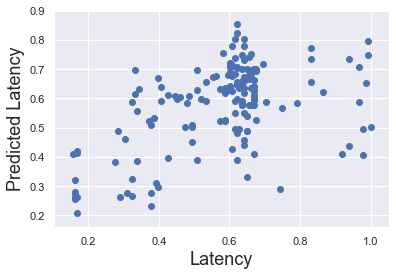

In [455]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [456]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.743,1.402
1,1.886,1.939
2,1.652,1.638
3,1.569,1.638
4,1.806,1.887


In [457]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.743,1.402,0.341,24.347
1,1.886,1.939,-0.053,2.749
2,1.652,1.638,0.014,0.848
3,1.569,1.638,-0.069,4.216
4,1.806,1.887,-0.081,4.297
...,...,...,...,...
154,1.793,1.616,0.177,10.947
155,1.967,1.837,0.130,7.081
156,2.182,1.837,0.345,18.803
157,1.879,1.776,0.103,5.822


In [458]:
perf.describe()

,prediction,target,residual,difference%
count,159.000,159.000,159.000,159.000
mean,1.798,1.811,-0.013,12.271
std,0.247,0.337,0.316,10.019
min,1.230,1.168,-1.164,0.084
25%,1.641,1.621,-0.134,4.256
50%,1.842,1.862,0.046,9.829
75%,1.970,1.926,0.201,17.110
max,2.353,2.718,0.617,44.275


In [459]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
108,1.38,1.38,-0.00,0.08
91,1.94,1.95,-0.01,0.51
89,1.89,1.87,0.01,0.68
158,1.89,1.90,-0.01,0.76
2,1.65,1.64,0.01,0.85
62,1.95,1.93,0.02,1.27
138,1.66,1.64,0.03,1.53
56,1.91,1.87,0.03,1.79
29,1.87,1.84,0.03,1.79
32,1.92,1.89,0.03,1.79


# Prediction Accuracy

In [460]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.20196025602119916


In [461]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.16684133447446536
